In [76]:
import pandas as pd
from IPython.display import display
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams


from tqdm import tqdm
import seaborn as sns
import os
from library.sb_utils import save_file

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score



In [77]:
data=pd.read_csv('../data/Preprocessed_data/data_cleaned.csv', index_col='Date', parse_dates=True)
earnings=pd.read_csv('../data/Preprocessed_data/earnings_cleaned.csv', index_col='Date', parse_dates=True)

In [78]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [79]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-25,13.00,13.25,12.611,13.15,13.15,1877800
2014-07-28,13.05,13.25,12.800,12.84,12.84,292500
2014-07-29,12.85,13.00,12.560,12.90,12.90,103300
2014-07-30,13.00,13.07,12.810,12.94,12.94,80600
2014-07-31,12.94,13.09,11.900,12.86,12.86,154300


In [80]:
earnings.head()

,EPS,Revenue
Date,,
2024-05-07,-0.24,14.77
2024-03-11,-0.28,14.80
2023-11-07,-0.51,15.08
2023-08-07,-0.27,15.19
2023-05-08,-0.31,13.37


Let’s check the data there is null or not and the shape of the data.

In [81]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [82]:
data.shape

(2507, 6)

In [83]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [84]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Daily Closing Price - plot

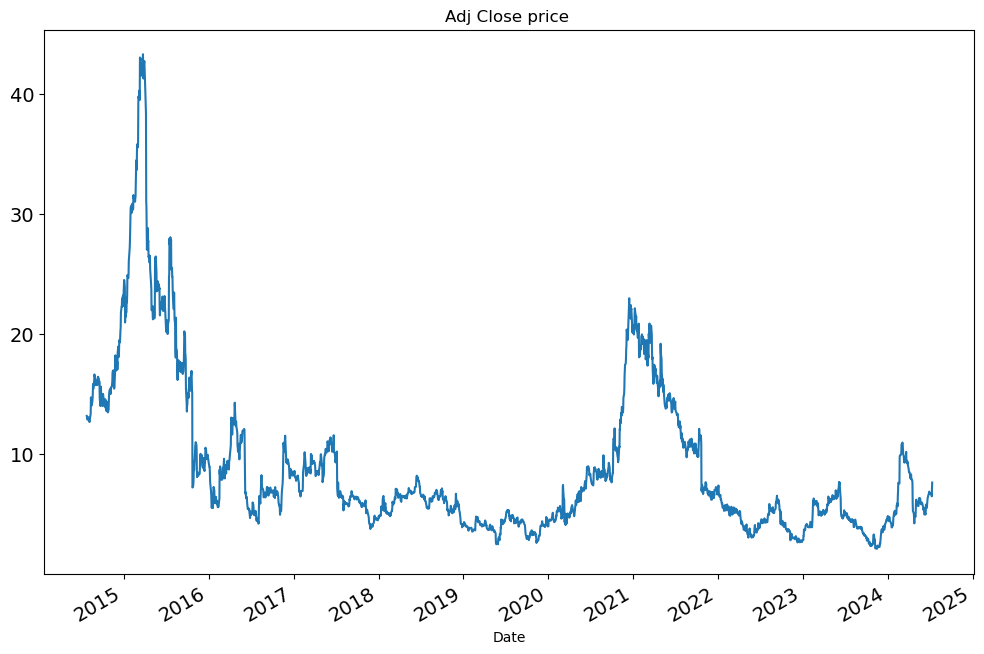

In [85]:
data_d = data.groupby(['Date'])['Adj Close'].mean()
data_d.plot(figsize=(12,8), title = 'Adj Close price ', fontsize=14);

The correlation heatmap

<Axes: >

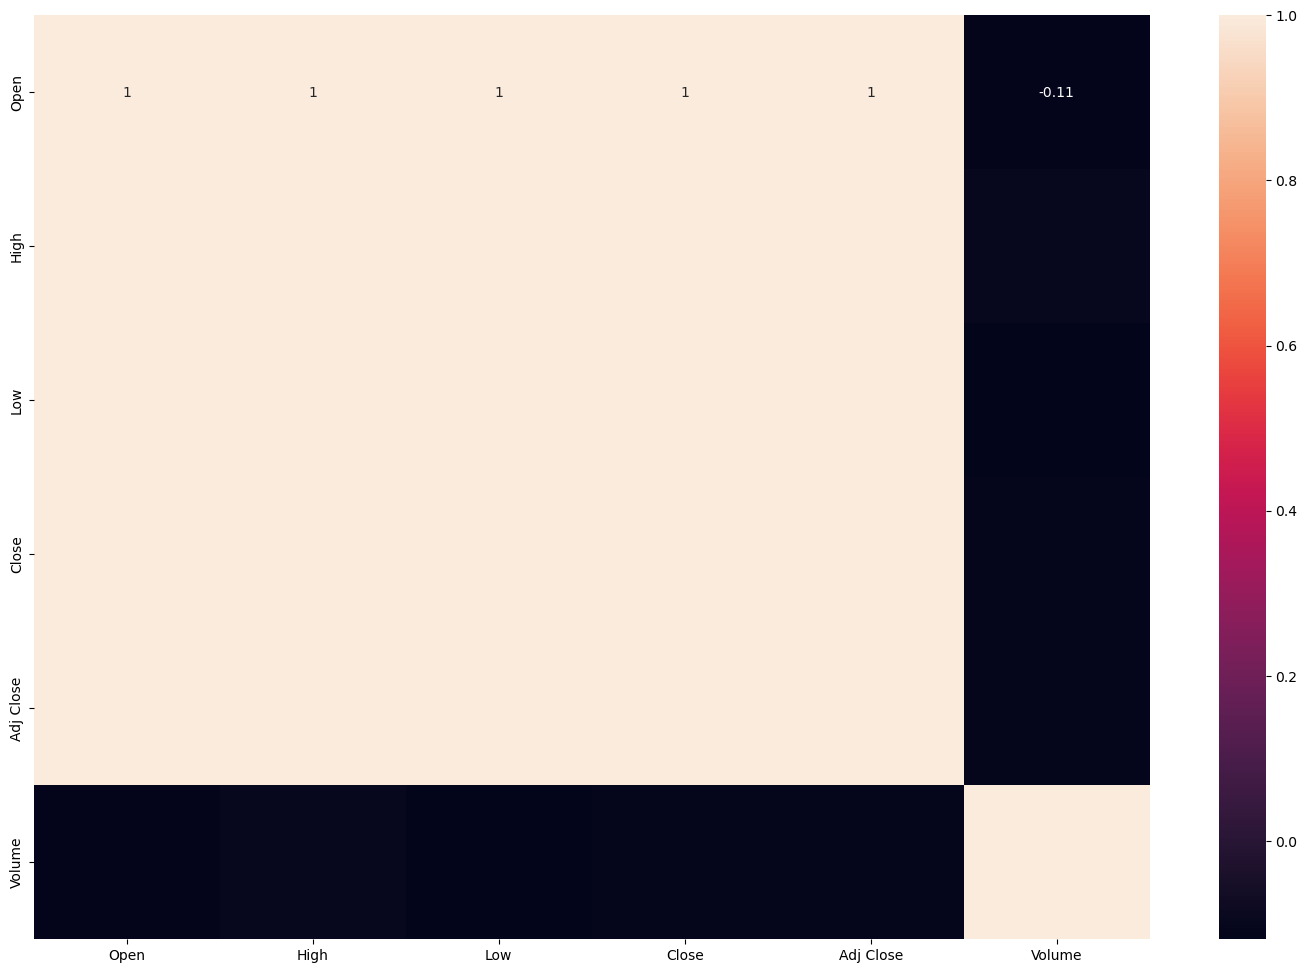

In [86]:
corr = data.corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True)

### Create a new DataFrame daily_diff, of changes in daily prices using the .diff() method and compute autocorrelation of the 'Adj Close' column in daily_diff using the .autocorr() method

In [87]:
daily_diff = data.diff()
daily_diff.dropna(inplace=True)
daily_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-28,0.05,0.000,0.189,-0.31,-0.31,-1585300.0
2014-07-29,-0.20,-0.250,-0.240,0.06,0.06,-189200.0
2014-07-30,0.15,0.070,0.250,0.04,0.04,-22700.0
2014-07-31,-0.06,0.020,-0.910,-0.08,-0.08,73700.0
2014-08-01,0.05,0.239,0.970,0.18,0.18,-22100.0
...,...,...,...,...,...,...
2024-07-05,-0.01,-0.175,-0.170,-0.02,-0.02,261400.0
2024-07-08,0.06,0.130,0.180,-0.01,-0.01,237700.0
2024-07-09,-0.08,-0.130,-0.170,-0.21,-0.21,-291600.0


### Compute the autocorrelation of daily changes

In [88]:
autocorrelation_daily = daily_diff['Adj Close'].autocorr()
autocorrelation_daily

0.04594527097307114

### Compute the autocorrelation of weekly changes

In [89]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [90]:

weekly_prices = data.resample(rule='W').last()
weekly_diff = weekly_prices.diff()
weekly_diff.dropna(inplace=True)

autocorrelation_weekly = weekly_diff['Adj Close'].autocorr()
autocorrelation_weekly

0.01925355820737013

### Compute the autocorrelation of monthly changes

In [91]:
monthly_prices = data.resample(rule='M').last()
monthly_diff = monthly_prices.diff()
monthly_diff.dropna(inplace=True)

autocorrelation_monthly = monthly_diff['Adj Close'].autocorr()
autocorrelation_monthly

-0.017835588476307253

### Compute the autocorrelation of annual changes

In [92]:
annual_prices = data.resample(rule='A').last()
annual_diff = annual_prices.diff()
annual_diff.dropna(inplace=True)

autocorrelation_annual = annual_diff['Adj Close'].autocorr()
autocorrelation_annual

-0.2713048145256302

**Note:** _the daily and weekly price changes have a positive autocorrelation meaning a **trend-following**, while the monthly and annual have a negative autocorrelation meaning a **mean-reverting** trend._ 

## Autocorrelation analysis
is the correlation of a single time series with a lagged copy of itself.

Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

What does it mean when a series has a positive or negative autocorrelation? With financial time series, when returns have a **negative autocorrelation**, we say it is **"mean reverting".**

Alternatively, if a series has **positive autocorrelation**, we say it is **"trend-following".**


Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up

The OCUL stock price show a negative autocorrelation only for monthly and annual prices

 ## Analysis of the autocorrelation of weekly percent returns of OCUL stock from 2014 to 2024. 
 
 I'll start with a OCUL DataFrame of daily prices.

In [93]:
OCUL_daily_returns= data['Adj Close'].pct_change()
# .ffill(): Forward fills any missing values (fills gaps with the previous value).
OCUL_monthly_returns = data['Adj Close'].resample('M').ffill().pct_change()


Looking at the head of the daily returns

In [94]:
OCUL_daily_returns.head()

Date
2014-07-25         NaN
2014-07-28   -0.023574
2014-07-29    0.004673
2014-07-30    0.003101
2014-07-31   -0.006182
Name: Adj Close, dtype: float64

Looking at the head of the monthly returns.

In [95]:
OCUL_monthly_returns.head()

Date
2014-07-31         NaN
2014-08-31    0.280715
2014-09-30   -0.091075
2014-10-31    0.020040
2014-11-30    0.108055
Freq: M, Name: Adj Close, dtype: float64

Charting the daily and monthly for OCUL

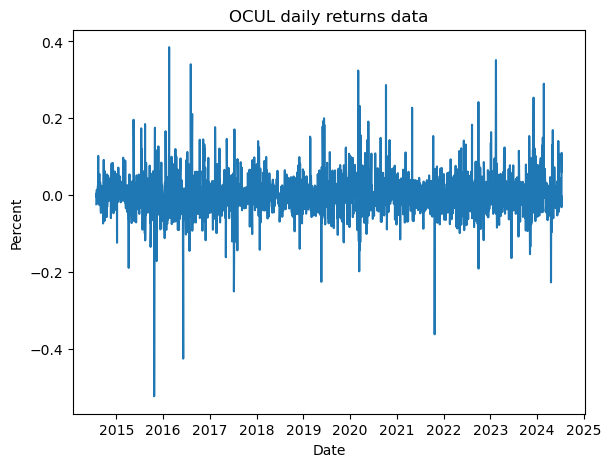

In [96]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(OCUL_daily_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("OCUL daily returns data")
plt.show()

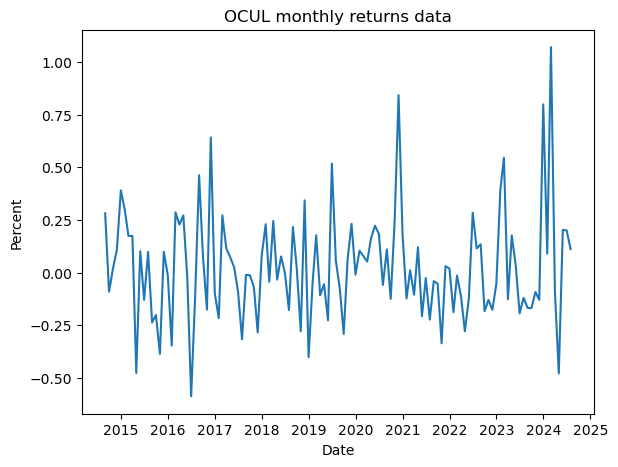

In [97]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(OCUL_monthly_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("OCUL monthly returns data")
plt.show()

After looking at the daily returns chart for OCUL we can conclude that the returns are quite volatile and the stock can move +/- 2% on any given day. To get a sense of how extreme the returns can be we can plot a histogram.

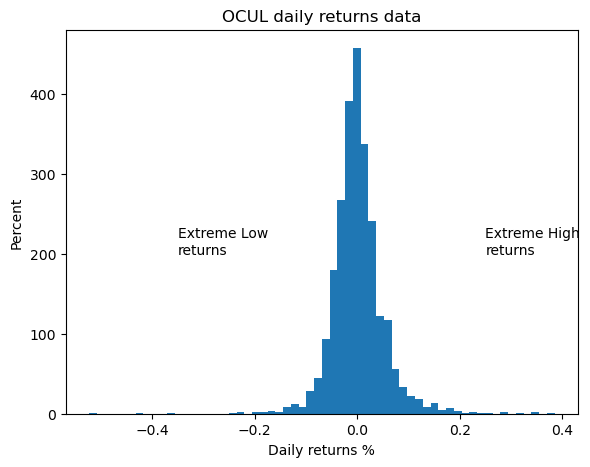

In [98]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
OCUL_daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("OCUL daily returns data")
ax1.text(-0.35,200,"Extreme Low\nreturns")
ax1.text(0.25,200,"Extreme High\nreturns")
plt.show()

Calculating the cumulative returns for the OCUL stock

To calculate the growth of OCUL investment or in other word, calculating the total returns from an investment in OCUL, we need to calculate the cumulative returns from that investment. To calculate the cumulative returns we will use the cumprod() function.

In [99]:
OCUL_cum_returns = (OCUL_daily_returns + 1).cumprod()

Next we can chart the cumulative returns of Netflix.

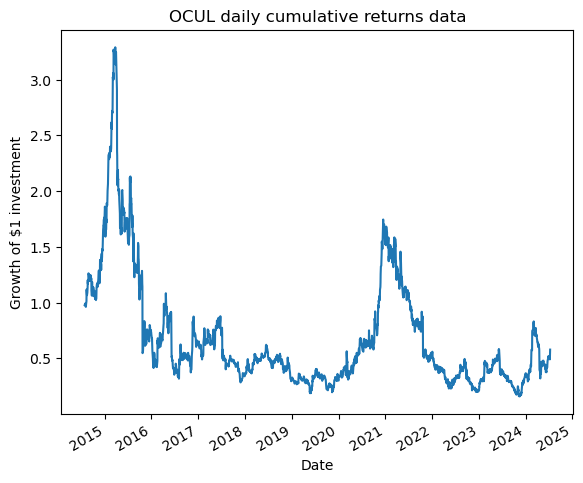

In [100]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
OCUL_cum_returns.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("OCUL daily cumulative returns data")
plt.show()

This chart shows the cumulative returns since 2014 for OCUL.

With the power of hindsight, one would have lost $0.50 on a $1 investment since 2014. That is quite a remarkable loss over so many years. For a research and medical treatment company it's not unusual, though. During the 10 year or so period there were times when the investment tripled its value. Very few investors can time exits and entry into investments through such periods.

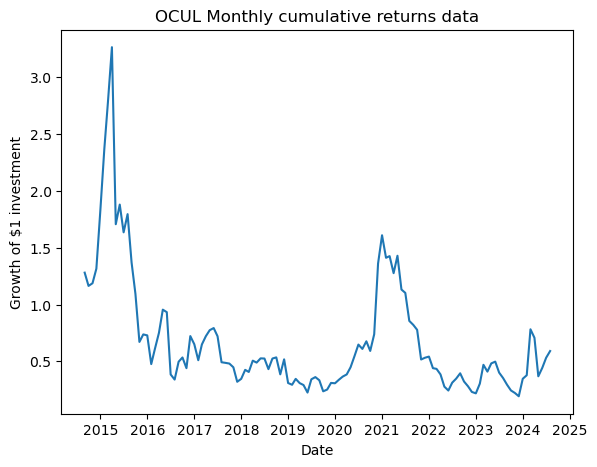

In [101]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
OCUL_cum_returns = (OCUL_monthly_returns + 1).cumprod()
ax1.plot(OCUL_cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("OCUL Monthly cumulative returns data")
plt.show()

The monthly returns chart is much more smoother than the daily chart.

In [102]:
# use the .resample() method to get weekly prices and then compute percent returns from prices.
# The "rule" argument indicates the desired frequency. Here "W" stands for weekly. 
# Here I used 'last' for the last date of the period. 


OCUL_weekly = data.resample(rule='W').last()
OCUL_weekly.dropna(inplace=True)
OCUL_weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2014-07-27 to 2024-07-14
Freq: W-SUN
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       521 non-null    float64
 1   High       521 non-null    float64
 2   Low        521 non-null    float64
 3   Close      521 non-null    float64
 4   Adj Close  521 non-null    float64
 5   Volume     521 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 28.5 KB


In [103]:
# compute the returns, the percentage change of prices

returns_weekly = OCUL_weekly.pct_change()
returns_weekly.dropna(inplace=True)

returns_weekly

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-08-03,-0.000769,0.005962,0.020538,-0.008365,-0.008365,-0.929598
2014-08-10,-0.021555,-0.021682,-0.013209,-0.006902,-0.006902,-0.729198
2014-08-17,0.119748,0.111196,0.086614,0.082625,0.082625,-0.698324
2014-08-24,0.101743,0.102139,0.081159,0.097718,0.097718,5.944444
2014-08-31,0.052296,0.036944,0.072386,0.070175,0.070175,-0.344000
...,...,...,...,...,...,...
2024-06-16,0.007828,0.151515,0.038618,0.163968,0.163968,1.245927
2024-06-23,0.176699,0.029605,0.166341,0.086957,0.086957,0.460908
2024-06-30,0.112211,0.110224,0.117450,0.094400,0.094400,0.103600


### Next, notice below how the autocorrelation of weekly returns for OCUL is negative  -0.04, so the stock is 'mean reverting'

In [104]:
# Compute the autocorrelation of returns

autocorrelation_weekly = returns_weekly['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation_weekly))

The autocorrelation of weekly returns is -0.04


### Same analysis for monthly returns

In [105]:
OCUL_monthly = data.resample(rule='M').last()
returns_monthly = OCUL_monthly.pct_change()
returns_weekly.dropna(inplace=True)

autocorrelation_monthly = returns_monthly['Adj Close'].autocorr()

print("The autocorrelation of monthly returns is %4.2f" %(autocorrelation_monthly))


The autocorrelation of monthly returns is 0.03


**Note:**_Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up_

OCUL has a weekly return autocorrerlation  of **-0.04**, **mean-reverting**, and a monthly return autocorrelation of **0.03**, as expected.

## Autocorrelation Function   (ACF)
which shows not only the lag-one autocorrelation, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past. 

Note: The ACF at lag=0 is always one

### Simple Autocorrelation Function 

This autocorrelation function implies that you can forecast the next value of the series from the last two values, since the lag-one and lag-two autocorrelations differ from zero.

### ACF for OCUL earnings

In [106]:
OCUL_earnings = earnings['EPS']  # we look at earnings, which is a good indicator for stock price direction

In [107]:
# Compute the acf array of OCUL earnings
acf_array_earnings = acf(OCUL_earnings)
acf_array_earnings

array([ 1.00000000e+00,  3.19624065e-02,  4.95409402e-02, -6.03885719e-03,
        4.34122455e-02,  1.52328864e-02,  2.97757024e-02,  6.50285308e-03,
       -9.57312378e-03, -3.93616601e-02,  7.84844117e-04,  9.23954035e-02,
        5.45708532e-02,  3.08043912e-02,  3.29229767e-02, -1.79724367e-02,
       -3.89894762e-02])

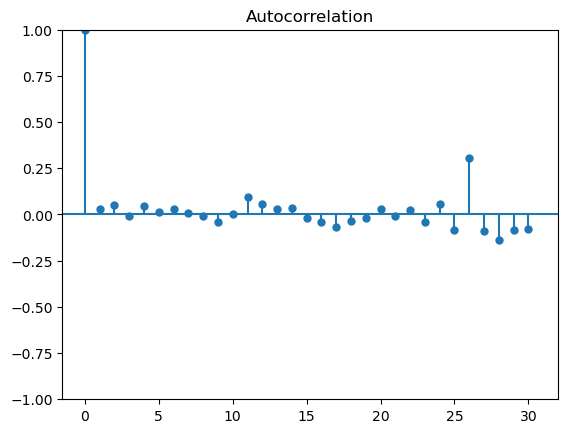

In [108]:
plot_acf(OCUL_earnings, alpha = 1, lags=30)
plt.show()

Note: a lag periods of 26, 27, 28, 29 are significantly negative compared to other lag periods, reflecting that at this lag values, the earnings have a stronger mean-reverting trend.

### ACF for OCUL stock price (daily, weekly, monthly)

In [161]:
OCUL_stock_price = data['Adj Close']  # we look at stock price now, the 'Adj Close' daily series
OCUL_stock_price.reset_index()
OCUL_stock_price  # is a series, not a data frame


Date
2014-07-25    13.15
2014-07-28    12.84
2014-07-29    12.90
2014-07-30    12.94
2014-07-31    12.86
              ...  
2024-07-05     6.67
2024-07-08     6.66
2024-07-09     6.45
2024-07-10     7.16
2024-07-11     7.60
Name: Adj Close, Length: 2507, dtype: float64

In [162]:
OCUL_stock_price.isna().sum()

0

In [163]:
#date_range = pd.date_range(start='2024-01-11', end='2024-07-11', freq='D')
#OCUL_stock_price=pd.DataFrame(OCUL_stock_price, index=date_range)
OCUL_stock_price.dropna(inplace=True)

In [164]:
OCUL_stock_price.shape

(2507,)

In [165]:
# Compute the acf array of OCUL stock price for 2024
acf_array_stock = acf(OCUL_stock_price)
acf_array_stock

array([1.        , 0.99668982, 0.9930905 , 0.98921799, 0.98502807,
       0.98070853, 0.97646312, 0.97210304, 0.96761902, 0.96313762,
       0.95877508, 0.954497  , 0.95017894, 0.94593424, 0.94155125,
       0.9371153 , 0.93272023, 0.92818729, 0.92332791, 0.91821855,
       0.9129161 , 0.90756726, 0.90200449, 0.89654548, 0.89148144,
       0.88622959, 0.88091648, 0.87615608, 0.8715237 , 0.86682596,
       0.8623285 , 0.85789906, 0.85351778, 0.84923426])

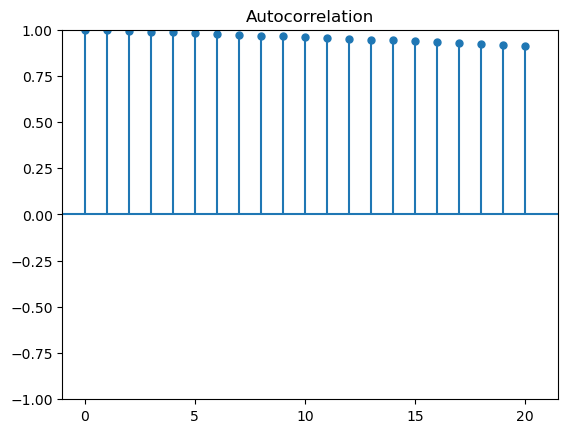

In [166]:
plot_acf(OCUL_stock_price, alpha = 1, lags=20)
plt.show()

### ACF for OCUL weekly prices

In [167]:
OCUL_weekly = data.resample(rule='W').last()
OCUL_weekly.shape

(521, 6)

In [168]:
OCUL_weekly = data.resample(rule='W').last()
OCUL_weekly_stock_price =OCUL_weekly['Adj Close']  # select the series 'Adj Close'
OCUL_weekly_stock_price.shape

(521,)

In [169]:
acf_array_stock_weekly = acf(OCUL_weekly_stock_price)
acf_array_stock_weekly

array([1.        , 0.97927799, 0.95773891, 0.93745509, 0.91444126,
       0.8881728 , 0.86789202, 0.84577591, 0.82294287, 0.80275115,
       0.77985472, 0.75907964, 0.73923988, 0.71741206, 0.69384096,
       0.67851051, 0.66185725, 0.64184693, 0.62463922, 0.60486118,
       0.58460907, 0.56441526, 0.54517772, 0.52315179, 0.5080048 ,
       0.49087195, 0.47085958, 0.4516869 ])

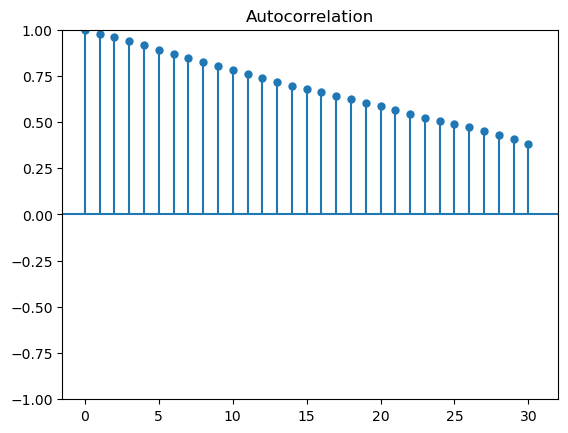

In [170]:
plot_acf(OCUL_weekly_stock_price, alpha = 1, lags=30)
plt.show()

### ACF for OCUL monthly prices

In [171]:
OCUL_monthly = data.resample(rule='M').last()
OCUL_monthly_stock_price =OCUL_monthly['Adj Close']
acf_array_stock_monthly = acf(OCUL_monthly_stock_price)
acf_array_stock_monthly

array([ 1.        ,  0.90464599,  0.80967284,  0.70719398,  0.63276856,
        0.55418446,  0.4629303 ,  0.35868151,  0.25953146,  0.1875139 ,
        0.12418398,  0.07596802,  0.04500067,  0.01881341, -0.00426308,
       -0.04371278, -0.07194144, -0.09078946, -0.09665119, -0.09909287,
       -0.08384491])

In [172]:
OCUL_monthly_stock_price.shape

(121,)

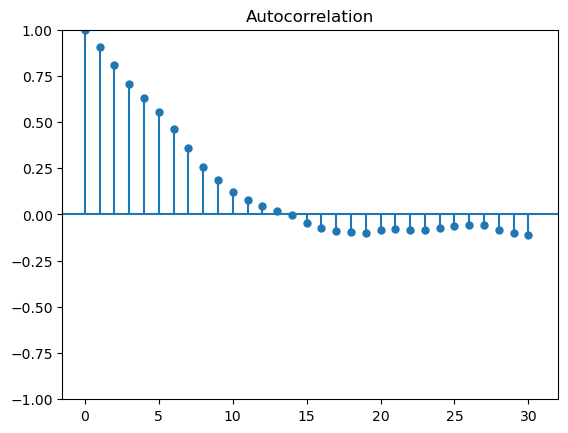

In [173]:
plot_acf(OCUL_monthly_stock_price, alpha = 1, lags=30)
plt.show()

Note: the **revert to mean** trend is present in monthly autocorrelation analysis starting at lags periods of 14 and up

### Random Walk - today's price is equal to yesterday's price plus some noise
One can't forecast a random walk. The best guess for tomorrow's price is simply today's price.

### Statistical Test for Random Walk

To test whether a series like stock prices follows a random walk, I regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then I cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then I can reject the null hypothesis that the series is a random walk.

This is called the "Dickey-Fuller" test  ***ADF test***. If I add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.

In [174]:
# run augmented Dickey_Test

results_price = adfuller(data['Adj Close'])
print('the p-value of the test on prices is: '+ str(results_price[1]))

the p-value of the test on prices is: 0.11405949301223856


The main output we're interested in is the **p-value** of the test. If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. In this case, the p-value is much higher than 0.05 - it's **0.11**. 

**Therefore, we cannot reject the null hypothesis that the OCUL stock price is a random walk.**

### Next I will do the same thing for OCUL returns, 
"OCUL_ret", (percent change in prices) **and show that the returns do not follow a random walk.**

In [175]:
# Create a Dataframe of OCUL returns
OCUL_ret = data.pct_change()
OCUL_ret.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-25,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-28,0.003846,0.000000,0.014987,-0.023574,-0.023574,-0.844233
2014-07-29,-0.015326,-0.018868,-0.018750,0.004673,0.004673,-0.646838
2014-07-30,0.011673,0.005385,0.019904,0.003101,0.003101,-0.219748
2014-07-31,-0.004615,0.001530,-0.071038,-0.006182,-0.006182,0.914392


In [176]:
# Eliminate the NaN in the first row of returns
OCUL_ret = OCUL_ret.dropna()
OCUL_ret.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-28,0.003846,0.000000,0.014987,-0.023574,-0.023574,-0.844233
2014-07-29,-0.015326,-0.018868,-0.018750,0.004673,0.004673,-0.646838
2014-07-30,0.011673,0.005385,0.019904,0.003101,0.003101,-0.219748
2014-07-31,-0.004615,0.001530,-0.071038,-0.006182,-0.006182,0.914392
2014-08-01,0.003864,0.018258,0.081513,0.013997,0.013997,-0.143227


In [177]:
# Run the ADF test on the returns series and print out the p-value
results_ret = adfuller(OCUL_ret['Adj Close'])
print('the p-value of the test on returns is: '+ str(results_ret[1]))


the p-value of the test on returns is: 0.0


### The p-value is zero, so we can easily reject the hypothesis that returns are a random walk at al levels of significance

### Check for Stationarity

Next:  If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. I may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate

### Transforming Nonstationary OCUL Series Into Stationary Series

**Looking at the ACF of OCUL's quarterly earnings, there is a seasonal component, about every 8 or 9 periods.**

In [178]:
# seasonally adjust quarterly earnings
OCUL_season = OCUL_earnings.diff(9)
OCUL_season

Date
2024-05-07     NaN
2024-03-11     NaN
2023-11-07     NaN
2023-08-07     NaN
2023-05-08     NaN
2023-03-06     NaN
2022-11-07     NaN
2022-08-08     NaN
2022-05-09     NaN
2022-02-28    0.01
2021-11-08    0.05
2021-08-09    0.40
2021-05-05    0.03
2021-03-11   -0.90
2020-11-05    0.03
2020-08-07   -0.34
2020-05-08   -0.13
2020-03-12   -0.31
2019-11-12   -0.22
2019-08-07   -0.34
2019-05-10   -0.34
2019-03-07   -0.18
2018-11-07    0.83
2018-08-07   -0.16
2018-05-08    0.24
2018-03-08   -0.03
2017-11-07   -0.01
2017-08-08   -0.19
2017-05-05   -0.01
2017-03-10   -0.07
2016-11-09    0.03
2016-08-09   -0.08
2016-05-10   -0.07
2016-03-10   -0.03
2015-11-10   -0.03
2015-08-10    0.09
2015-05-15    0.29
2015-03-10    0.21
2014-11-12    0.04
2014-08-28   -1.71
Name: EPS, dtype: float64

In [179]:
# Drop the NaN data in the first 9 rows
OCUL_season = OCUL_season.dropna()
OCUL_season

Date
2022-02-28    0.01
2021-11-08    0.05
2021-08-09    0.40
2021-05-05    0.03
2021-03-11   -0.90
2020-11-05    0.03
2020-08-07   -0.34
2020-05-08   -0.13
2020-03-12   -0.31
2019-11-12   -0.22
2019-08-07   -0.34
2019-05-10   -0.34
2019-03-07   -0.18
2018-11-07    0.83
2018-08-07   -0.16
2018-05-08    0.24
2018-03-08   -0.03
2017-11-07   -0.01
2017-08-08   -0.19
2017-05-05   -0.01
2017-03-10   -0.07
2016-11-09    0.03
2016-08-09   -0.08
2016-05-10   -0.07
2016-03-10   -0.03
2015-11-10   -0.03
2015-08-10    0.09
2015-05-15    0.29
2015-03-10    0.21
2014-11-12    0.04
2014-08-28   -1.71
Name: EPS, dtype: float64

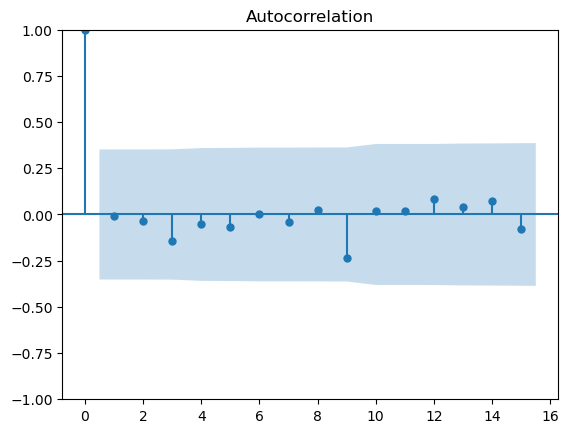

In [180]:
# plot the autocrrelation function of the seasonally adjusted series
plot_acf(OCUL_season)
plt.show()

### By seasonally adjusting the series, I eliminated the seasonal pattern in the autocorrelation function

In [181]:
OCUL_stock.shape

NameError: name 'OCUL_stock' is not defined

## Forecasting with an AR model

In [182]:
# If the index of the data is a DatetimeIndex object as it is here, 
# I can pick dates for the start and end date

#OCUL_stock.index

Training and test datasets:- It is important we do not randomly pick training and testing datasets. In stock price prediction, we have to use the test data always the recent dataset give a better result for our prediction.

Training dataset is 80% of the total dataset while the test dataset the remaining 20%.

In [183]:
X_train = data[:2004]  # 80%
X_test = data[2004:]   #20%

<Figure size 1200x800 with 0 Axes>

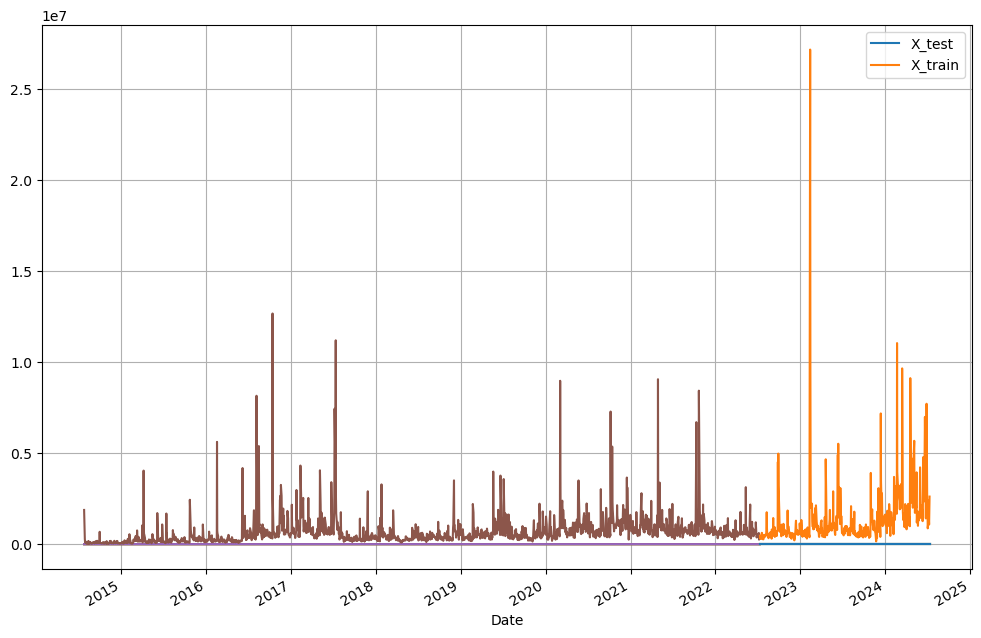

In [184]:
plt.figure(figsize = (12,8));
ax = X_train.plot(grid=True, figsize = (12,8));
X_test.plot(ax=ax, grid=True);
plt.legend(['X_test', 'X_train']);
plt.show();

## ARIMA model:

ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q). Where:

 - p is the order of the autoregressive model(number of time lags)
 - d is the degree of differencing (number of times the data have had past values subtracted)
 - q is the order of moving average model. Before building an ARIMA model, we have to make sure our data is stationary.
 
Before going to the ARIMA model, we have to make our data is stationarize. For a data to be stationarize:

 - The mean of the series should not be a function of time.
 - The variance of the series should not be a function of time.
 - the covariance of the i th term and the (i + m) th term should not be a function of time.
 
 There are two methods to check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test.

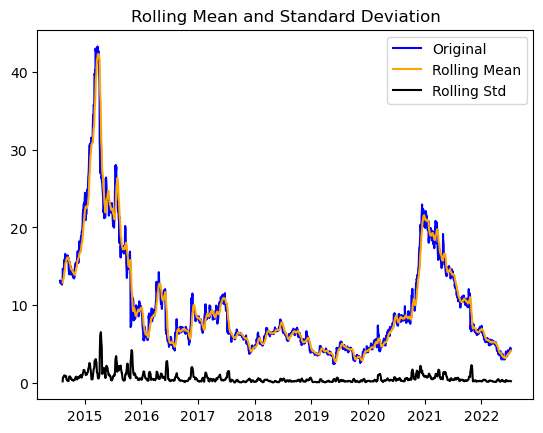

Results of Dickey-Fuller Test:
Test Statistic            -2.037845
p-value                    0.270230
#Lgas used                 3.000000
Nr of observations      2000.000000
Critical Value (1%)       -3.433624
Critical Value (5%)       -2.862986
Critical Value (10%)      -2.567540
dtype: float64


In [185]:
# define function for ADF test

def adf_test_stationary(timeseries):
        
    # Determine rolling statistics mean and stdev
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color = 'blue', label='Original')
    plt.plot(rolmean, color = 'orange', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
        
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lgas used', 'Nr of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
            
    # apply adf test on the series
adf_test_stationary(X_train['Adj Close'])

We can easily see that the time series is not stationary, and our adf_test_stationarity function confirms what we see.

To transform our data more stationary I stationarize our data such using first Difference

I use Plot the ACF and PACF charts and find the optimal parameters. The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. 

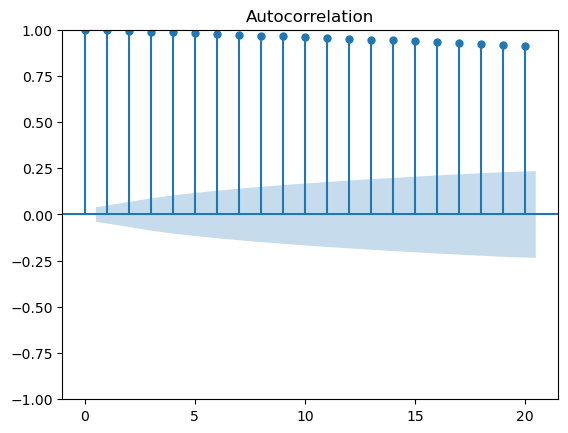

In [186]:
plot_acf(data['Adj Close'], lags=20)
plt.show()

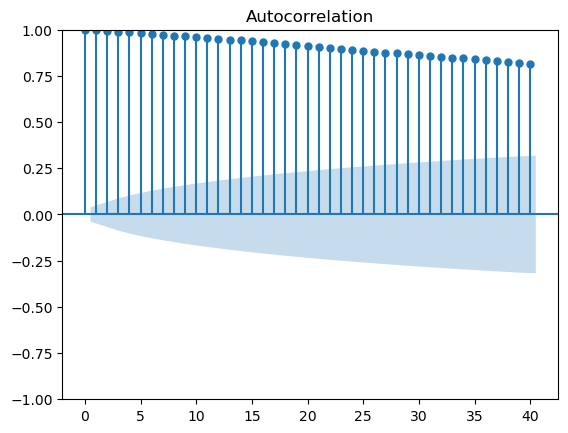

In [187]:
plt = sm.graphics.tsa.plot_acf(data['Adj Close'], lags=40)
plt.show()

we are using Plot the ACF and PACF charts and find the optimal parameters. The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. 

### Estimating and Forecasting an AR Model

	Create an instance of the ARIMA class called mod using the OCUL stock price data and the order (p,d,q) of the model (in this case, for an AR(1)), is order=(1,0,0).

In [188]:
# Fit an AR(1) model to the data
mod = ARIMA(OCUL_stock_price[:2004], order=(1,0,0))  # 1 for order 1 AR model, 0 for assuming no differences
# were taken in the series, and 0 for MA
res = mod.fit()

In [189]:
# print out summary information on the fit
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2004
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1743.551
Date:                Fri, 19 Jul 2024   AIC                           3493.102
Time:                        14:25:31   BIC                           3509.911
Sample:                             0   HQIC                          3499.273
                               - 2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8871      4.839      2.043      0.041       0.402      19.372
ar.L1          0.9967      0.001    835.183      0.000       0.994       0.999
sigma2         0.3328      0.002    136.468      0.000       0.328       0.338
===================================================================================
Ljung-Box (L1) (Q):                   4.36   Jarque-Bera (JB):            129650.19
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [190]:
# to see the coefficients rather than the entire regression output, 
# I use the params property, which returns an array of the fitted coefficients.
res.params

const     9.887079
ar.L1     0.996716
sigma2    0.332767
dtype: float64

In [191]:
fig, ax = plt.subplots()
OCUL_stock_price[:2004].plot(ax=ax)
OCUL_stock_price[2004:].plot(ax=ax)

plot_predict(res, alpha = 0.05, ax=ax)
plt.show()

TypeError: cannot unpack non-iterable Axes object